# Introduction to analysing social behaviour using networks

CMT224: Social Computing

<br>
<br>

## Case Study

## Dataset: Reddit Hyperlinks

>![Reddit][1]
>
> Reddit is social news aggregation, web content rating, and discussion website. Users submit content to the site such as links, text posts, images, and videos into virtual spaces called "subreddits" - in a similar manner to internet forums. Subreddits can cover a variety of general or very specific topics within news, politics, religion, science, movies, video games, music, books, etc. Posts can then be commented on and voted up or down by other members. Submissions with more upvotes appear towards the top of their subreddit and, if they receive enough upvotes, ultimately on the site's front page.
>
> Although there are strict rules prohibiting harassment, it still occurs, and Reddit administrators moderate the communities and close or restrict them on occasion. Moderation is also conducted by community-specific moderators, who are not considered Reddit employees.  -- Wikipedia [Paraphrased].
>
> https://www.reddit.com/
>

[1]: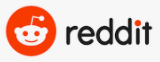


- The variety of social features of the Reddit platform provide a means to build all sorts of networks to represent and investigate social ties/connections and/or other socially-driven behaviour on the platform.

- Here we will look at one particular aspect of Reddit, 'community' interactions, where for simplicity communities are individual subreddits. In particular, we will look at user posting behaviour within subreddits where a user's post includes a hyperlink to some other subreddit, i.e. subreddit A is talking about subreddit B by linking to some post in subreddit B.

- We will build networks from the post behaviour and use various (but not exhaustive) analysis methods to reveal social behaviour patterns in the community interactions. However, unlike some of the other notebooks, here nodes will represent subreddits/communities rather than individual users.

- The dataset used in this notebook is a sample of a much larger dataset available at: https://snap.stanford.edu/data/soc-RedditHyperlinks.html. This is one of several public datasets of Reddit data. The paper the dataset is attached to: Kumar, Srijan, William L. Hamilton, Jure Leskovec, and Dan Jurafsky. "Community interaction and conflict on the web." In Proceedings of the 2018 world wide web conference, pp. 933-943. 2018. https://arxiv.org/abs/1803.03697.


---

<font color="#F4A460">This exercise assumes a Python 3 ipykernel environment. </font>

<font color="#F4A460"> If you are not running a virtual environment, run the cell below. Or if you are running a virtual environment, install networkx, matplotlib, etc, and jupyter/ipykernel in the virtual environment instead. </font>


In [25]:
%pip install networkx numpy scipy

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


---
<br>

In [26]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import operator
import json
from scipy import stats

<br>
<br>

<br/>

## 1. Building a network from the Reddit post data

### Understanding the raw dataset

- Here we don't have a pre-built network to analyse, we must instead build a suitable network or networks from the data first to then analyse.

- The dataset in question is a JSON-formatted list of data spanning one-month of Reddit posts. 

Each list item refers to a single post and contains some information about each post (although note the text of the post is not included, nor the comments of the post). The values for SOURCE and TARGET are pseudonymised so can be considered as subreddit 'ids'. Post ids are also pseudonymised.

Example Reddit post information from the dataset:
```json
[{  
	"SOURCE": "9263",  e.g. r/conspiracy
	"TARGET": "2175",  e.g. r/news
	"POST": "1729",
	"SENTIMENT": 1,
	"TIMESTAMP": "2024-01-01 00:11:15"
}, ... ]
```

Definitions (as per the authors of the original paper): 
>
> **SOURCE**: the subreddit where the link originates
>
> **TARGET**: the subreddit where the link ends
>
> **POST**: the post in the source subreddit that starts the link
>
> **TIMESTAMP**: the time of the post
>
> **SENTIMENT**: label indicating if the source post is explicitly negative towards the target post. The value is -1 if the source is negative towards the target, and 1 if it is neutral or positive. "The label is created using **crowd-sourcing** and training a text based classifier, and is better than simple sentiment analysis of the posts". See the research paper for more details.


<br>
<br>

### Creating a 'social network' of subreddits with NetworkX

The data contains several pieces of information about each Reddit post. As a result, there are different ways a network structure could be constructed and it may also not be appropriate to try and embed every piece of data into a single network representation.

We first need to define a scope for the network (or networks) based on some overarching research question(s) or hypothesis/hypotheses. 

This *could be*: Does the cumulative behaviour of communities talking about one another expose social behaviours that in turn manifest into similar properties of a social network structure between individual people? 


In [27]:
# Use Python's json package to read the data into a Python list.

data = []

with open("reddit-sample_2024.json") as json_file:
    data = json.load(json_file)

print(f"Number of posts: {len(data)}")

# Print the first 5 posts (items in the list)
for post in data[:5]:
    print(post)

Number of posts: 24325
{'SOURCE': '6241', 'TARGET': '6338', 'POST': '17280', 'SENTIMENT': 1, 'TIMESTAMP': '2024-01-01 00:11:15'}
{'SOURCE': '8374', 'TARGET': '3505', 'POST': '11975', 'SENTIMENT': 1, 'TIMESTAMP': '2024-01-01 00:15:06'}
{'SOURCE': '789', 'TARGET': '664', 'POST': '21347', 'SENTIMENT': 1, 'TIMESTAMP': '2024-01-01 00:17:05'}
{'SOURCE': '1638', 'TARGET': '1141', 'POST': '13543', 'SENTIMENT': 1, 'TIMESTAMP': '2024-01-01 00:17:33'}
{'SOURCE': '3416', 'TARGET': '6883', 'POST': '17918', 'SENTIMENT': 1, 'TIMESTAMP': '2024-01-01 00:20:10'}


<br>
<br>

#### Choosing a type of Graph

A key component of the data is that each post is a subreddit referencing another subreddit and therefore each post arguably isn't a mutual interaction between nodes.

Lets refer to the NetworkX documentation for a list of different types of Graphs (that it supports):

https://networkx.org/documentation/stable/reference/classes/index.html

Two immediate choices given what the edges could represent are a **Directed Graph (DiGraph object)** or a **Directed MultiGraph (MultiDiGraph object)**.


A **Directed MultiGraph** may be seen as the most appropriate choice as the data could contain multiple individual posts from a 'SOURCE' subreddit to a 'TARGET' subreddit over the time period the data covers. Directed MultiGraphs can be seen as more complex to analyse with many 'traditional' graph theory methods available concentrating on Undirected or Directed graphs (although many have extensions continue to be proposed in research papers). They can also offer more opportunities for a richer analysis where, for example, temporal data is embedded on the edges (see Extra: Temporal motifs, below).

Instead, the data could be represented as a **Directed Graph, with edge weights** that represent the number of posts. This has the benefit of allowing weights to be considered for some analyses and not for others.

For this notebook, we will choose the later and explore what it can help uncover from the data and what its limitations are.


> **Extra**: Temporal motifs: https://snap.stanford.edu/temporal-motifs/

<br>
<br>

#### An initial network model using a Directed Graph

For an initial, simple model of the data we will create a NetworkX DiGraph object and then loop over every post in the data and add an edge from the "SOURCE" subreddit of a post and the "TARGET" subreddit of a post.

Each edge will represent that the "SOURCE" subreddit refers to another "TARGET SUBREDDIT" at least once. We will consider weight later in the analysis.


In [28]:
G = nx.DiGraph() # Start from an empty DiGraph object https://networkx.org/documentation/stable/reference/classes/digraph.html

for post in data:
    G.add_edge(post["SOURCE"], post["TARGET"])   # NetworkX will add nodes if they dont exist in the DiGraph object before it adds an edge.
    
    # If an edge already exists then another will not be added. 


In [29]:
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

Number of nodes: 9011
Number of edges: 18283


In [30]:
print(f"Number of posts: {len(data)}")

Number of posts: 24325


<br>
<br>

---

<br>
<br>

## 2. Does its structure resemble a typical social network?

The nodes in the network are communities (subreddits), not individual people. However, the edges between them are built from underlying individual user behaviour, i.e. posts by users of a community (subreddit) talk about and reference posts made by users in another community (subreddit).

This leads to the question of whether the resulting network exhibits similar structural characteristics that are typically seen in social networks.

Lets start by examining the density of the network


In [31]:
print(f"Density (or sparsity): {nx.density(G):.5f}") #note, nx.density(G) not G.density()

Density (or sparsity): 0.00023


The network is very sparse which shows that not all subreddits are talking about each other. 

In the context of Reddit's content structure, is this surprising?

<br>
<br>

Lets look at the distribution of edges across the nodes (subreddits):

In [32]:
degree_sequence = [degree for (node, degree) in nx.degree(G)]

print("Descriptive Statistics:\n")

print(f"Mean degree: {np.mean(degree_sequence):.2f}")
print(f"Std. deviation: {np.std(degree_sequence):.2f}")
print(f"Range: {np.amin(degree_sequence)} to {np.amax(degree_sequence)}")
print(f"Median degree: {np.median(degree_sequence)}")

Descriptive Statistics:

Mean degree: 4.06
Std. deviation: 13.20
Range: 1 to 458
Median degree: 1.0


The majority of subreddits are only connected to a small number of other subreddits, but there is at least one with hundreds of connections. Again, in the context of Reddit's content structure, is this surprising?

This leads to the question of: Is the subreddit with the largest degree an anomaly or are more like it?


In [33]:
# 20 nodes (subreddits) highest and lowest degrees

reverse_sorted_degree_sequence = sorted(degree_sequence, reverse=True)

print(reverse_sorted_degree_sequence[:20])

print(reverse_sorted_degree_sequence[-20:])

[458, 414, 330, 288, 222, 219, 210, 210, 205, 198, 187, 173, 152, 147, 145, 135, 121, 119, 119, 117]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


<br>

The shape of the distribution (with a likely long-tail) *could be* indicative of a "small-world" network structure as often seen in social networks. This motivates looking at clustering and paths in the network.

<br>
<br>

### "Small-World"-ness and separation

Networks that exhibit "small-world" properties, typically have:

- A higher average clustering coefficient than a comparable random network;
- A short average path length.

Lets try and calculate these for our Reddit network.


> **Extra**: Refer to the Twitch network notebook for more information on the characteristics of small-world network structures.

In [34]:
#https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.cluster.average_clustering.html
print(f"Average clustering coefficient in the network: {nx.average_clustering(G):.3f}")

#https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.shortest_paths.generic.average_shortest_path_length.html

#Uncomment
#print(f"Average shortest path length in the network: {nx.average_shortest_path_length(G):.2f}")

Average clustering coefficient in the network: 0.050


- The average clustering coefficient is low in absolute terms;
- The average shortest path length calculation fails with NetworkX stating: "Graph is not weakly connected." The network is disconnected such that a path cannot be drawn between all nodes. The network could be seen as being made up of multiple (sub-)networks, without any edges between them.

<br>

However, network disconnection is not unusual for complex networks in general terms and itself is an aspect to explore further.

<br>
<br>

**Extra**: Similar issues occur for many random networks with the same number of nodes and edges.

In [35]:
R = nx.gnm_random_graph(G.number_of_nodes(), G.number_of_edges(), seed=100, directed=True) # Example, seeded random graph

print(f"Average clustering coefficient in a random network: {nx.average_clustering(R):.5f}")

#Uncomment
#print(f"Average shortest path length in a random network: {nx.average_shortest_path_length(R):.2f}")


Average clustering coefficient in a random network: 0.00030


<br>
<br>

Likewise, the disconnected network prevents examining the degrees of separation:

In [36]:
#Uncomment
#nx.diameter(G)

Although the average clustering coefficient of this Reddit network is small in absolute terms, it is notably higher than an example random network. Despite this, the "small-world"-ness of the network is difficult to support due to the network being disconnected. 


<br>
<br>

### Connectedness

NetworkX provides API methods for investigating the extent to which a network is 'connected' or 'disconnected'. Depending on whether the graph/network is directed or undirected, this can mean slightly different things: https://networkx.org/documentation/stable/reference/algorithms/component.html

For undirected Graphs/networks, a network is disconnected if a path cannot be drawn from every node to every other node. Each subset of nodes where a path can be drawn is called a 'Connected Component'. 


> ![Connected Components][1] - Ha-Myung Park, et al



[1]: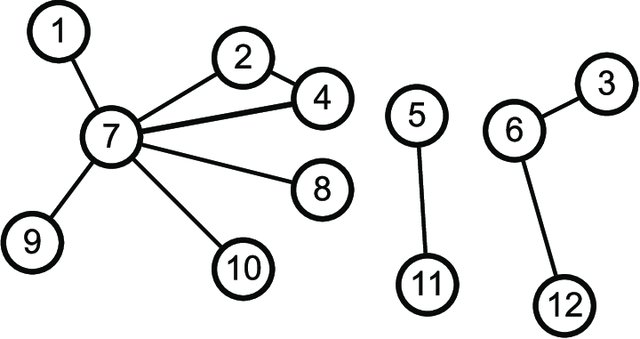


<br>
<br>

For directed Graphs/networks, two notable measures are:

- **Weakly connected components**, which are similar to connected components for undirected networks where a set of nodes are weakly connected if a path can be drawn between every node and every other in the set, while ignoring the direction of the edges.
    
- **Strongly connected components**, which are similar but considers edge direction. 



> ![Strongly/Weakly Connected Components][2] - Adèle W. Zendrera, et al

However, isolated nodes without an edge going to and from at least one other node can also be counted as a strongly connected component.

[2]: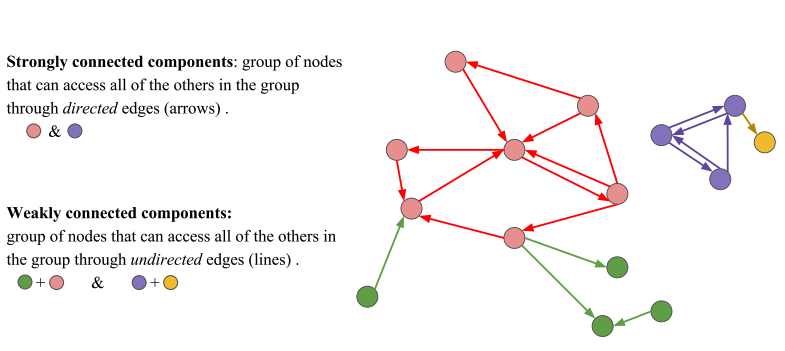

<br>
<br>

#### A network of networks?

Lets explore this for our Reddit network.

> The documentation pages for each method can be found at: 
>
> https://networkx.org/documentation/stable/reference/algorithms/component.html


Firstly,

1. Is the entire network strongly connected?
2. Is the entire network weakly connected?

In [37]:
strongly_connected = nx.is_strongly_connected(G)
weakly_connected = nx.is_weakly_connected(G)

print(f"Is the entire network strongly connected: {strongly_connected}")
print(f"Is the entire network weakly connected: {weakly_connected}")

Is the entire network strongly connected: False
Is the entire network weakly connected: False


<br/>

1. How many strongly connected components are there?
2. How many weakly connected components are there?

In [38]:
number_scc_components = nx.number_strongly_connected_components(G)
number_wcc_components = nx.number_weakly_connected_components(G)

print(f"Number of strongly connected components: {number_scc_components}")
print(f"Number of weakly connected components: {number_wcc_components}")

Number of strongly connected components: 7254
Number of weakly connected components: 441


<br/>

1. How many nodes are there in each strongly connected component?
2. How many nodes are there in each weakly connected component?

In [39]:
scc_components = nx.strongly_connected_components(G) # get the list of nodes in each strongly connected component

number_of_nodes_per_strongly_connected_component = []                       # create an empty list to store the number of nodes in each component
for component in scc_components:                                            # loop over each strongly connected component
    number_of_nodes_per_strongly_connected_component.append(len(component)) # add the length of the strongly connected component (a list of nodes) to the new list

number_of_nodes_per_strongly_connected_component = sorted(number_of_nodes_per_strongly_connected_component, reverse=True) # sort by largest to smallest

print("Number of nodes in the 100 largest strongly connected components:\n")
print(number_of_nodes_per_strongly_connected_component[:100], "...")


### Repeat for weakly connected components

number_of_nodes_per_weakly_connected_component = sorted([len(wcc) for wcc in nx.weakly_connected_components(G)], reverse=True) # this line compresses the equivalent code in lines 1-7 for weakly connected components

print("\nNumber of nodes in the 100 largest weakly connected components:\n")
print(number_of_nodes_per_weakly_connected_component[:100], "...\n\n")


Number of nodes in the 100 largest strongly connected components:

[1630, 8, 7, 6, 5, 5, 5, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1] ...

Number of nodes in the 100 largest weakly connected components:

[7977, 9, 9, 9, 8, 7, 7, 7, 7, 7, 6, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2] ...




<br>
<br>

The results show that the network includes a notably large strongly connected component (and weakly connected component) alongside lots of smaller components (i.e, containing a small number of nodes). At this point we have a few options, each with their own pros and cons, including:

1. Repeat (and continue) the analysis on each strongly/weakly connected component. However, this creates challenges in summarising behaviour with the different number of nodes/edges in each.
2. Focus on the strongly/weakly component that captures the majority of nodes in the network, sometimes considered the "Giant Component". However, you may miss important structural properties of the overall network.
3. Add synthetic edges to the network to connect the components together, e.g., randomly choosing nodes in each component to join together or selecting the nodes based on some node property (e.g., largest degree). This somewhat addresses the 'cons' of 1 and 2 but introduces the possibility of significantly changing any results. However this process can be useful to explore for other network tasks that are not about decomposition and analysis of a network, e.g., in deciding which edges to introduce into a network to enable or improve information flow:


> **Extra**: NetworkX Connectivity - Edge-augmentation 
>
> https://networkx.org/documentation/stable/reference/algorithms/connectivity.html

<br>
<br>

#### Does a network representing the largest strongly connected component exhibit 'Small-World' properties?

We can isolate our analysis to the concentrated connectivity in the network by examining the behaviour among the subreddits in the largest strongly connected component (i.e., option 2).

To do this we will utilise the concept of an (induced) subgraph. https://networkx.org/documentation/stable/reference/classes/generated/networkx.Graph.subgraph.html

The induced subgraph will only contain the nodes in the largest strongly connected component and the edges between them.

In [40]:
# Retrieve the list of strongly connected components, sorted by the number nodes in each component and do so in reverse order.

# 1. Retrieve the strongly connected components in the network, G
strongly_connected_components = nx.strongly_connected_components(G) # returns a generator of sets, (but could be seen as a list of lists)

# 2. Sort these by their size (number of nodes in them)
strongly_connected_components_sorted_by_number_of_nodes = sorted(
    strongly_connected_components, 
    key=len, # sort by the length of each item (in this case set of nodes)
    reverse=True # in reverse order
)

# 3. Take the set of nodes in the largest strongly connected component, i.e. the first item.
list_of_nodes_in_largest_strongly_connected_component = strongly_connected_components_sorted_by_number_of_nodes[0]

# 4. Extract a subgraph of the original network that only includes the nodes in the largest strongly connected component and the edges between them
LSCC = G.subgraph(list_of_nodes_in_largest_strongly_connected_component).copy()



<br>
<br>

In [41]:
print(f"Number of nodes in G: {G.number_of_nodes()}")
print(f"Number of nodes in the largest strongly connected component of G: {LSCC.number_of_nodes()}")

Number of nodes in G: 9011
Number of nodes in the largest strongly connected component of G: 1630


In [42]:
print(f"Number of edges in G: {G.number_of_edges()}")
print(f"Number of edges in the largest strongly connected component of G: {LSCC.number_of_edges()}")

Number of edges in G: 18283
Number of edges in the largest strongly connected component of G: 7340


<br/>

This removes a notable proportion of nodes and edges, but enables us to repeat the investigations into the "small-world" phenomenon:

In [43]:
print(f"Average shortest path length in G's largest strongly connected component: {nx.average_shortest_path_length(LSCC):.3f}")
print(f"Average clustering coefficient in G's largest strongly connected component: {nx.average_clustering(LSCC):.3f}")


Average shortest path length in G's largest strongly connected component: 5.477
Average clustering coefficient in G's largest strongly connected component: 0.164


<br>

In [44]:
R = nx.gnm_random_graph(LSCC.number_of_nodes(), LSCC.number_of_edges(), seed=100, directed=True)

In [93]:
# Will throw a NetworkXError: Graph is not strongly connected
#print(nx.average_shortest_path_length(R))

The nature of many random graph/network generators is the (often lack of) connectivity of the resulting graph; especially in directed, low density random graphs.

We could generate a random network and then try and rewire it to make a single strongly connected component, but that is complex and may produce doubts in the randomness.

Or we could consider the networks/components as undirected - but this isn't guaranteed to result in a connected graph either.

Or we could only consider the shortest path lengths where nodes can reach one another. This is how NetworkX defined the average shortest path length in versions < 3.0. This is arguably more straightforward but comes with the need to cavaet the results that you are comparing a strongly connected sub-graph (in this case) with a potentially disconnected random network (which has the same number of nodes and edges).

To do the later, we can implement the algorithm on the NetworkX average shortest path length documentation page (https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.shortest_paths.generic.average_shortest_path_length.html), while only considering path lengths where pairs of nodes are "reachable from each other". To do this, nx.single_source_shortest_path_length()(https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.shortest_paths.unweighted.single_source_shortest_path_length.html) can be used (as well as other alternatives) to avoid having to check whether the node pairs are "reachable":

In [45]:
def average_shortest_path_length_disconnected(N):
    total_shortest_distances = sum(target_node_distance for source_node in N for target_node_distance in nx.single_source_shortest_path_length(N, source_node).values())
    number_of_nodes = len(N)
    return total_shortest_distances / (number_of_nodes * (number_of_nodes - 1))


This method produces the same answer as the NetworkX average_shortest_path_length API for the network's largest strongly connected component:

In [46]:
print(f"{nx.average_shortest_path_length(LSCC):.2f}")
print(f"{average_shortest_path_length_disconnected(LSCC):.2f}")

5.48
5.48


<br>
<br>

In [47]:
R = nx.gnm_random_graph(LSCC.number_of_nodes(), LSCC.number_of_edges(), seed=100, directed=True) # Example, seeded random graph

# note the different method call, rather than nx.average_shortest_path_length(..)
print(f"Average shortest path length in a random network: {average_shortest_path_length_disconnected(R):.2f}")
print(f"Average clustering coefficient in a random network: {nx.average_clustering(R):.4f}")


Average shortest path length in a random network: 4.97
Average clustering coefficient in a random network: 0.0026


<br> 

To summarise:

- The average clustering coefficient of the LSCC has increased in comparison to the entire network;
- The average clustering coefficient of the LSCC is notably higher than the random graph;
- The average shortest path length of the LSCC is similar to the random network.

From this, there is arguably partial support for 'small-world' properties among nodes in the largest, strongly connected component. 

<br>
<br>

### Summary of observations:

- An overarching observation across the questions investigated is the limited connectivity in the network.

- The differences between strongly and weakly connected components in the network also motivates investigating the direction of edges in more detail to further unpick the possible social behaviours driving the network.


<br>
<br>

---

<br>
<br>

## 3. Are communities mutually talking about each other?

The directed nature of the network allows further social factors to be examined, including the presence of dyadic behaviours between pairs of communities and common roles that communities have based on the direction of their connections.

<br>

### Reciprocity

In social psychology, reciprocity is a social norm of responding to a positive action with another positive action, rewarding kind actions - Wikipedia.
Similar concepts exist for more negative actions, i.e., retaliation, tit-for-tat.

In a Graph/Network context, reciprocity is a generalised term that examines the extent that links between nodes are asymmetric (i.e., one-way edge) or mutual (edges in both directions). Here it can be used to help understand the extent that pairs of communities reference each other.

NetworkX provides an implementation for calculating the reciprocity of the overall network:

> NetworkX Documentation: The reciprocity of a directed graph is defined as the ratio of the number of edges pointing in both directions to the total number of edges in the graph.
>
> ```python
> nx.overall_reciprocity(...)
> ```
https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.reciprocity.overall_reciprocity.html#networkx.algorithms.reciprocity.overall_reciprocity

In [48]:
print(f"Overall Reciprocity of G: {nx.overall_reciprocity(G):.3f}")
print(f"Density of G : {nx.density(G):.5f}") # For extra context


Overall Reciprocity of G: 0.086
Density of G : 0.00023


In [49]:
print(f"Overall Reciprocity of G's largest strongly connected component: {nx.overall_reciprocity(LSCC):.2f}")
print(f"Density of G's largest strongly connected component : {nx.density(LSCC):.4f}") # For extra context

Overall Reciprocity of G's largest strongly connected component: 0.18
Density of G's largest strongly connected component : 0.0028


<br>

- Overall, many pairs of communities do not have reciprocated references to one another in the data.
- While the reciprocity of the largest, strongly connected component is higher, it is also low in absolute terms. This suggests that the number of paths between nodes in the network may be limited.


<br>
<br>

**Extra**: Reciprocity can also be measured at a local level for each node:

NetworkX Documentation: The reciprocity of a single node u is defined similarly, it is the ratio of the number of edges in both directions to the total number of edges attached to node u.
> 
> ```python
> nx.reciprocity(...)
> ```
> 
https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.reciprocity.reciprocity.html

In [77]:
reciprocity_per_node = nx.reciprocity(G, G.nodes())

print("\nIndividual Reciprocity for 5 example nodes in G (id, reciprocity):")
print(list(reciprocity_per_node.items())[:5])

reciprocity_values = list(reciprocity_per_node.values())

print("\nDescriptive Statistics:\n")

print(f"Mean reciprocity: {np.mean(reciprocity_values):.2f}")
print(f"Std. deviation: {np.std(reciprocity_values):.2f}")
print(f"Range: {np.amin(reciprocity_values)} to {np.amax(reciprocity_values)}")
print(f"Median reciprocity: {np.median(reciprocity_values)}")




Individual Reciprocity for 5 example nodes in G (id, reciprocity):
[('6241', 0.0), ('6338', 0.09523809523809523), ('8374', 0.0), ('3505', 0.10714285714285714), ('789', 0.0)]

Descriptive Statistics:

Mean reciprocity: 0.05
Std. deviation: 0.17
Range: 0.0 to 1.0
Median reciprocity: 0.0


Some observations:

- The average reciprocity of a node is lower than the overall reciprocity of the network;
- Some communities are either only reference other communities (out edges), or are only referenced to by other communities (in edges);
- A MultiDiGraph model could provide further insights on the reciprocity results here if time and sentiment data were embedded into the edges, e.g. is the reciprocation possibly immediate retaliation? More on this at the end of the Notebook.

### Unpicking common 'types' of communities

The reciprocity findings motivate taking a closer look at the direction of the connections (edges) of nodes and whether communities have common 'roles' in the network as defined by the types of edges coming to/from them. 

#### To what extent are subreddits only referenced by other subreddits, only reference others, or both?

Lets examine the direction of edges coming 'in' and 'out' of a node. Firstly, for a basis of comparison, we can use NetworkX's degree(...) to get the number of edges irrespective of the direction.
https://networkx.org/documentation/stable/reference/classes/generated/networkx.DiGraph.degree.html#networkx.DiGraph.degree

In [78]:
# Create a fixed node order for safety for Python < 3.7
nodeOrder = list(G.nodes())

# In directed networks, the 'degree' is the number of edges coming 'out' of a node + the number coming 'in', i.e., the number of edges in either direction
degree_per_node = G.degree(nodeOrder)

print("\nDegree for 6 example nodes in G (id, in+out degree):") 
print(list(degree_per_node)[:6])



Degree for 6 example nodes in G (id, in+out degree):
[('6241', 18), ('6338', 21), ('8374', 1), ('3505', 56), ('789', 1), ('664', 458)]


The number of edges coming 'in' and 'out' of a node can be retrieved using NetworkX's in_degree(...) and out_degree(...) methods respectively.

In [53]:
in_degree_per_node = G.in_degree(nodeOrder)
print("\nIn degree for 6 example nodes in G (id, in degree):") 
print(list(in_degree_per_node)[:6])

out_degree_per_node = G.out_degree(nodeOrder)
print("\nOut degree for 6 example nodes in G (id, out degree):") 
print(list(out_degree_per_node)[:6])


In degree for 6 example nodes in G (id, in degree):
[('6241', 0), ('6338', 15), ('8374', 0), ('3505', 48), ('789', 0), ('664', 458)]

Out degree for 6 example nodes in G (id, out degree):
[('6241', 18), ('6338', 6), ('8374', 1), ('3505', 8), ('789', 1), ('664', 0)]



The six example nodes highlight the findings of the reciprocity analysis that the direction of all edges connected to a node can be asymmetric (i.e., either coming in or coming from) and unbalanced.

<br>

This motivates taking a census of the number of nodes that are either only referenced by others (only 'in' edges), only reference others (only 'out' edges), or a mix of both.


In [79]:
only_referenced_by_others = []
never_referenced_by_others = []
mix = []
no_edges = []

for node in nodeOrder: # For each node in the network
    
    # get its in_degree (number of edges coming in) and its out_degree (number of edges coming out)
    in_degree = G.in_degree(node)
    out_degree = G.out_degree(node)
    
    # check if there are only in edges, no out edges
    if in_degree > 0 and out_degree == 0:
        only_referenced_by_others.append(node)
        
    # check the reverse, if there are only out edges, no in edges
    elif in_degree == 0 and out_degree > 0:
        never_referenced_by_others.append(node)
        
    # check that they have both in and out edges
    elif in_degree > 0 and out_degree > 0:
        mix.append(node)
        
    else:
        no_edges.append(node)
        
print(f"Total number of communities (nodes): {len(nodeOrder)}")
print()
print(f"Number that are only referenced by others (only 'target' nodes): {len(only_referenced_by_others)}")
print(f"Number that are never referenced (i.e., only reference others / only 'source' nodes): {len(never_referenced_by_others)}")
print(f"Number that reference others and are referenced by others: {len(mix)}")
print(f"Number that have no edges : {len(no_edges)}")

Total number of communities (nodes): 9011

Number that are only referenced by others (only 'target' nodes): 2249
Number that are never referenced (i.e., only reference others / only 'source' nodes): 4267
Number that reference others and are referenced by others: 2495
Number that have no edges : 0


<br>
<br>

#### What is the relationship between the number of connections in and out of a subreddit community?

As an alternative analysis lens, lets take a look at the degree distribution(s). Refer back to the 'Twitch' data notebook for more information on this plot.

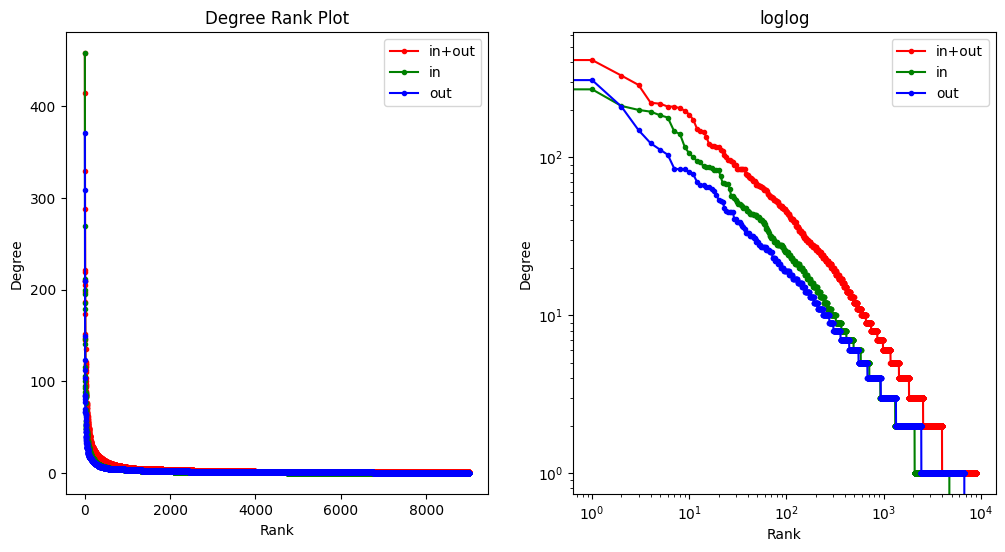

In [80]:
degree_sequence = sorted(dict(G.degree(nodeOrder)).values(), reverse=True) # in+out degree)
in_degree_sequence = sorted(dict(G.in_degree(nodeOrder)).values(), reverse=True)
out_degree_sequence = sorted(dict(G.out_degree(nodeOrder)).values(), reverse=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.plot(degree_sequence, "r-", marker=".", label="in+out")
ax1.plot(in_degree_sequence, "g-", marker=".", label="in")
ax1.plot(out_degree_sequence, "b-", marker=".", label="out")
ax1.set_title("Degree Rank Plot")
ax1.set_ylabel("Degree")
ax1.set_xlabel("Rank")
ax1.legend()

# https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.loglog.html
ax2.loglog(degree_sequence, "r-", marker=".", label="in+out")
ax2.loglog(in_degree_sequence, "g-", marker=".", label="in")
ax2.loglog(out_degree_sequence, "b-", marker=".", label="out")
ax2.set_title("loglog")
ax2.set_ylabel("Degree")
ax2.set_xlabel("Rank")
ax2.legend()
plt.show()


In [81]:
# Extra: Descriptive statistics on degree sequences

print("\nIn Degree Descriptive Statistics:")

print(f"Mean in degree: {np.mean(in_degree_sequence):.2f}")
print(f"Std. deviation: {np.std(in_degree_sequence):.2f}")
print(f"Range: {np.amin(in_degree_sequence)} to {np.amax(in_degree_sequence)}")
print(f"Median in degree: {np.median(in_degree_sequence)}")

print("\nOut Degree Descriptive Statistics:")
print(f"Mean out degree: {np.mean(out_degree_sequence):.2f}")
print(f"Std. deviation: {np.std(out_degree_sequence):.2f}")
print(f"Range: {np.amin(out_degree_sequence)} to {np.amax(out_degree_sequence)}")
print(f"Median in degree: {np.median(out_degree_sequence)}")


In Degree Descriptive Statistics:
Mean in degree: 2.03
Std. deviation: 9.41
Range: 0 to 458
Median in degree: 1.0

Out Degree Descriptive Statistics:
Mean out degree: 2.03
Std. deviation: 7.51
Range: 0 to 371
Median in degree: 1.0


- The in and out degree sequences have a similar shape with a small proportion of nodes having large in/out degrees and a 'long-tail' of small in/out degrees for the majority of nodes.

- Lets take a closer look at just the 'heads' of the distributions to check whether these are the same or different nodes?

<br>
<br>

In [82]:
# What are the largest in and out degrees? Are these the same communities (nodes)?

sorted_in_degree = sorted(in_degree_per_node, reverse=True, key=operator.itemgetter(1))
sorted_out_degree = sorted(out_degree_per_node, reverse=True, key=operator.itemgetter(1))

print("\n5 nodes in G with the largest 'in' degree (id, in degree):")
print(sorted_in_degree[:5])

print("\n5 nodes in G with the largest 'out' degree (id, out degree):")
print(sorted_out_degree[:5])




5 nodes in G with the largest 'in' degree (id, in degree):
[('664', 458), ('1987', 270), ('6140', 212), ('6076', 200), ('304', 195)]

5 nodes in G with the largest 'out' degree (id, out degree):
[('3511', 371), ('6218', 309), ('7774', 210), ('4642', 149), ('4572', 123)]


<br>

Lets expand this to consider the nodes with the largest 50 in degrees and largest 50 out degrees. and determine how many subreddit communities (nodes) are somewhere in both lists?


In [85]:

top_in_degree_nodes = set(node[0] for node in sorted_in_degree[:50]) #node[0] will extract the node id
top_out_degree_nodes = set(node[0] for node in sorted_out_degree[:50])

nodes_in_both = top_in_degree_nodes.intersection(top_out_degree_nodes)

print(f"Number of communities in both the top(largest) 50 'in' and 'out' degree lists: {len(nodes_in_both)}")



Number of communities in both the top(largest) 50 'in' and 'out' degree lists: 5


<br>
<br>

Lets explore the relationship between the in and out degree of nodes as a correlation. From the analysis on the census of nodes with only in edges or only out edges showing that this applies to the majority of nodes, it could be expected that overall there would be little correlation. 

In the following example we make some high-level assumptions about the data and choose a Pearson Correlation test for simplicity. Other statistical investigations and tests may provide further insight, but this is beyond the scope of this notebook.

> **Extra**: SciPy - Pearson Correlation: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pearsonr.html

In [86]:
in_degree_sequence = list(dict(G.in_degree(nodeOrder)).values())
out_degree_sequence = list(dict(G.out_degree(nodeOrder)).values())

r, p = stats.pearsonr(in_degree_sequence, out_degree_sequence)
print(f"pearson r: {r:.3f}, {p:.9f}") #see notebook Extra for information on how to interpret the output

pearson r: 0.208, 0.000000000


**Extra**: Broadly speaking,

>If the value of r is < 0, there is support of a negative correlation
>
>If the value of r is > 0, there is support of a positive correlation
>
>If the value of r is ~0, there is no support of a correlation

>Values in the region of (+/-)0.2 to 0.3 indicates a weak correlation
>
>Values in the region of (+/-)0.4 to 0.5 indicates a moderate correlation
>
>Values in the region of (+/-)0.6 to 0.7 indicates a strong correlation
>
>Values in the region of (+/-)0.8 to 1.0 indicates a very strong correlation

However, we should also pay attention to the 'p' value before concluding whether a positive/negative correlation is statistically significant and robust enough to conclude from:

>A p-value of < 0.05 is indicative of likely statistical significance
>
>A p-value of < 0.001 is indicative of strong likelihood of statistical significance

<br>
<br>

The results indicate a weak, positive correlation between the in degree and out degree of the nodes in the network. However, this masks the overarching observation of the imbalance between the in degree and out degree of nodes seen previously.

To show this further we can plot the 'in' degree values against the 'out' degree values.

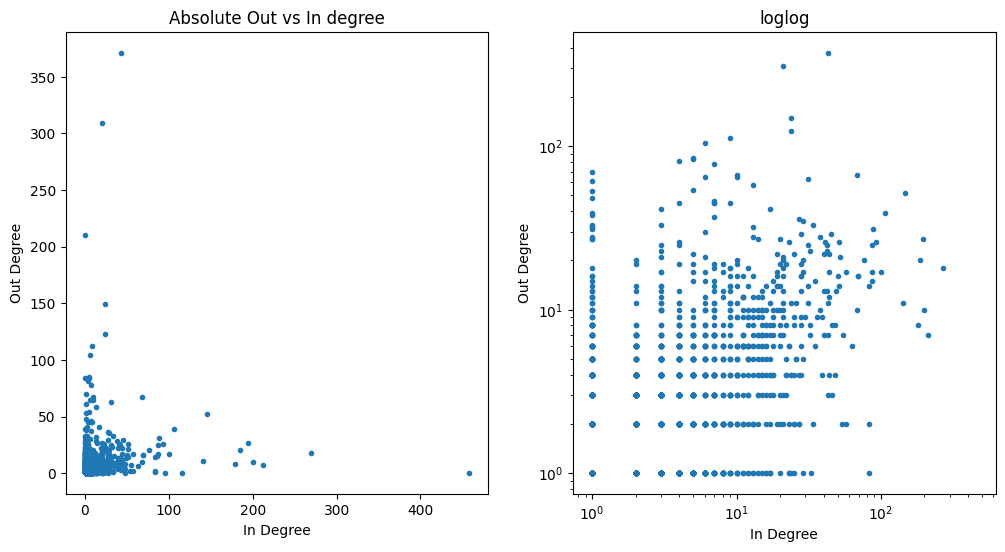

In [60]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.scatter(in_degree_sequence, out_degree_sequence, marker=".")
ax1.set_title("Absolute Out vs In degree")
ax1.set_ylabel("Out Degree")
ax1.set_xlabel("In Degree")

ax2.scatter(in_degree_sequence, out_degree_sequence, marker=".")
ax2.set_title("loglog")
ax2.set_ylabel("Out Degree")
ax2.set_xlabel("In Degree")
ax2.set_yscale('log')
ax2.set_xscale('log')

plt.show()

<br>
<br>

### Summary of observations:

- As well as being sparse, the network has little reciprocity;

- With communities mostly taking a role of only being referenced, or only referencing other communities;

- This is emphasised further by the in/out degree sequences highlighting extreme imbalances between the in and out degrees of some communities.


<br>
<br>

---

<br>
<br>

## 4. Summary and motivations going forward

1. Despite the freedom (generally speaking) of being able to post and comment in any subreddit and link between them, networks built from subreddits linking to others does not seem to strongly follow a "small-world" structure seen between social networks of people. 



2. In the sample of data that we have examined, subreddits are predominantly either 'sources' of links to other subreddits, or 'targets' (i.e., linked to) and the network is notably disconnected.


3. However, while this presents interesting insights into the general behaviours of communities linking/referencing one another this analysis arguably raises a lot more speculation and questions about the norms and behaviours that is driving community interactions on Reddit and the resulting characteristics of the network structure produced. For example:

    - The extreme differences in node (in+out) degree across the nodes could be indicative of whether a subreddit is themed around a specific topic (e.g., r/cardiff) or more generalised (e.g., r/news). However, the anonymisation of the data limits examining this.

    - The lack of reciprocity could be indicative of 'gossiping' being a dominant social behaviour of Reddit communities, but this motivates analysis of more contextual data such as the text of the post itself and the comments to substantiate this. 

    - Equally what reciprocity there is could be positive and highlight cooperation between communities or negative and indicate conflict between communities. Being able to effectively detect the difference between this could effect the viability of the creation of moderation tools.






4. Some of these examples could be examined by modelling more of the data into more complex networks - e.g., the POST and SENTIMENT and TIMESTAMP data of each post was not utilised here. However, others would require deanonymisation of the data and the collection of further data around posts and users to provide additional context. The original paper and dataset where this sample comes from (linked at the top of the notebook) goes much deeper in some of these areas. For example:

    > "We find that negative mobilizations (and mobilizations in general) tend to occur between highly similar communities... examining these community pairs reveals that they tend to focus on similar topics, but have different views on the subject matter (e.g., r/conspiracy vs. r/worldnews ...), which fits with previous discussions of this phenomenon..." -- Kumar et al.

5. However, while we should always be mindful of the ethical implications of the behaviour analysis we undertake and in the actions made/tools created from them.

<br>

**Along the way we have:**

- Taken a first look at using Python and NetworkX to build different networks from data and then analyse them.

- We've looked at more methods from graph theory that, while applied to specific questions on the Reddit data, are generalisable to analysis of other directed networks. In some areas we have also leaned on other statistical methods (e.g., Pearson Correlation Tests) data representations (e.g. logarithmic scales) in support of the network analysis.

- Some we will use again in later weeks and the rest we *could*. Equally there will be more methods introduced in later weeks/notebooks where you can go back and implement in this notebook as an extension of the Reddit analysis. Therefore the analysis here should not be considered exhaustive.



> **Optional Extra**: Repeat the analysis of this notebook using the larger, original dataset discussed at the start of this notebook. Please note that the original dataset is in a different file format than the sample used in this notebook and the existing cells for creating the network will need to be modified. In undertaking the analysis, observe the changes to the values for each part of the analysis and observe any notable context the non-anonymised subreddits bring to the conclusions.

<br>
<br>

---

<br>
<br>

## **Extra**: Does considering the volume of posts remove possible noise from the behaviour patterns seen?

Lets revisit our design choices in the network. We've used a directed graph, but not considered the number of times one subreddit/community links to another over time.

In the current network model, if a community (subreddit) links to another once or 100 times, it has no significance. This provides simplicity to the data modelling but may be weakening the ability to see the core, potentially frequent behaviours in the data.

### Building a weighted, directed network

As discussed in 1., we can model multiple posts using a directed network in different ways. Here we will increment the complexity of the network used so far by adding a 'weight' attribute to edges which will correspond to the number of times a community posted a link about another community. 

In [87]:
W = nx.DiGraph()

for post in data:
    
    # Check if the edge already exists in the network, if it does increment the weight value by 1
    if W.has_edge(post["SOURCE"], post["TARGET"]):         # https://networkx.org/documentation/stable/reference/classes/generated/networkx.Graph.has_edge.html
        W[post["SOURCE"]][post["TARGET"]]['weight'] += 1
        
    else: # If the edge does not yet exist in the network, add it with an initial weight value of 1
        W.add_edge(post["SOURCE"], post["TARGET"], weight=1)


In [62]:
print(f"Number of nodes: {W.number_of_nodes()}")
print(f"Number of edges: {W.number_of_edges()}")
print(f"Total of edge weights: {W.size(weight='weight')} (Number of posts)") # https://networkx.org/documentation/stable/reference/classes/generated/networkx.Graph.size.html

Number of nodes: 9011
Number of edges: 18283
Total of edge weights: 24325.0 (Number of posts)


The difference between the number of edges and the sum of the weights on all edges (i.e., number of posts in the dataset) is arguably small. However, this still may reveal different observations to the unweighted network.

<br/>

<br>
<br>

### Strength over degree?

Lets start with observing whether the shape of the degree distribution changes if weight is considered.

The sum of weights on edges is termed to be the node "strength". There is no dedicated NetworkX API method for strength, but it can be retrieved by passing an additional argument to the degree equivalent method's 'weight' parameter with the attribute name that represents edge weights - here also called 'weight'.

In [88]:
strength_sequence = sorted(dict(W.degree(nodeOrder, weight="weight")).values(), reverse=True)
in_strength_sequence = sorted(dict(W.in_degree(nodeOrder, weight="weight")).values(), reverse=True)
out_strength_sequence = sorted(dict(W.out_degree(nodeOrder, weight="weight")).values(), reverse=True)



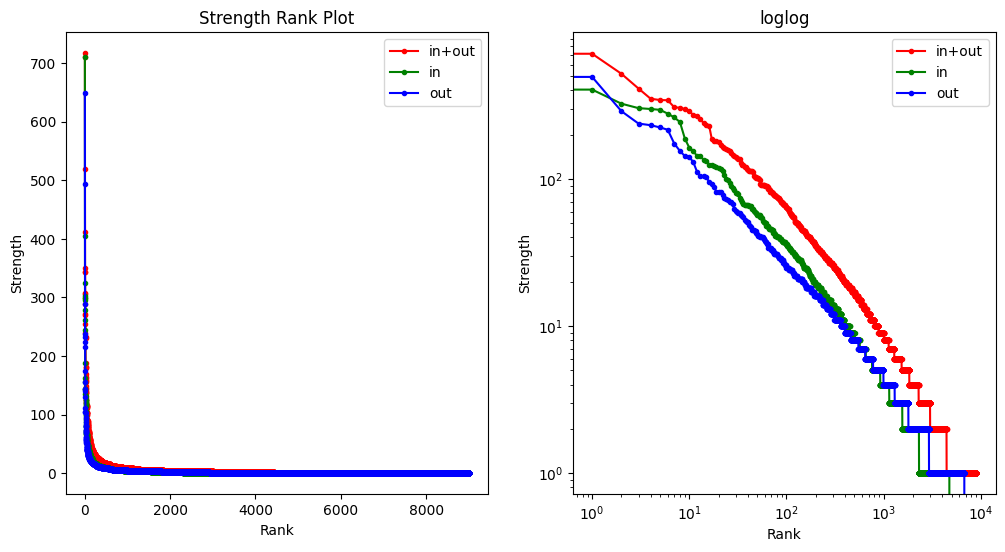


In Strength Descriptive Statistics:

Mean in strength: 2.70
Std. Deviation: 14.33 

Smallest in strength: 0
Largest in strength: 710 

Median in strength: 1



Out Strength Descriptive Statistics:

Mean out strength: 2.70
Std. Deviation: 12.26

Smallest out strength: 0
Largest out strength: 649

Median out strength: 1



In [89]:

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.plot(strength_sequence, "r-", marker=".", label="in+out")
ax1.plot(in_strength_sequence, "g-", marker=".", label="in")
ax1.plot(out_strength_sequence, "b-", marker=".", label="out")
ax1.set_title("Strength Rank Plot")
ax1.set_ylabel("Strength")
ax1.set_xlabel("Rank")
ax1.legend()

ax2.loglog(strength_sequence, "r-", marker=".", label="in+out")
ax2.loglog(in_strength_sequence, "g-", marker=".", label="in")
ax2.loglog(out_strength_sequence, "b-", marker=".", label="out")
ax2.set_title("loglog")
ax2.set_ylabel("Strength")
ax2.set_xlabel("Rank")
ax2.legend()
plt.show()


print("\nIn Strength Descriptive Statistics:\n")
print("Mean in strength: %.2f" % np.mean(in_strength_sequence))
print("Std. Deviation: %.2f \n" % np.std(in_strength_sequence))
print("Smallest in strength: %d" % np.amin(in_strength_sequence))
print("Largest in strength: %d \n" % np.amax(in_strength_sequence))
print("Median in strength: %.d\n\n" % np.median(in_strength_sequence))

print("\nOut Strength Descriptive Statistics:\n")
print("Mean out strength: %.2f" % np.mean(out_strength_sequence))
print("Std. Deviation: %.2f\n" % np.std(out_strength_sequence))
print("Smallest out strength: %d" % np.amin(out_strength_sequence))
print("Largest out strength: %d\n" % np.amax(out_strength_sequence))
print("Median out strength: %.d\n" % np.median(out_strength_sequence))


When visualised, the node strength distribution follows a similar shape to the degree distribution. However the different scale on the y axis should be noted. This suggests that the majority of posts are from a small number of nodes about a small number of other nodes.

Lets perform a similar correlation analysis to the original network, but using the in and out node strengths, rather than degree.

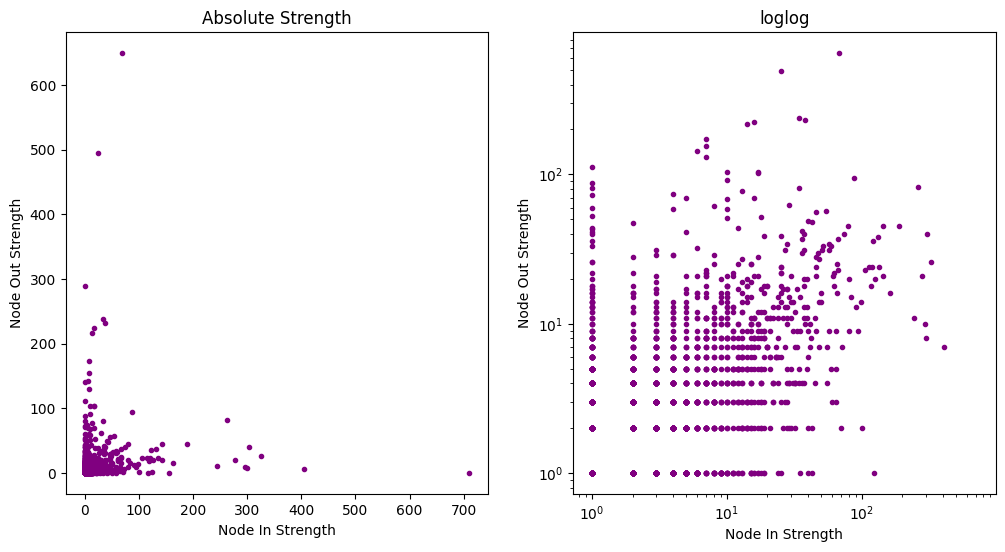

pearson r: 0.180, p: 0.000


In [65]:
strength_sequence = list(dict(W.degree(nodeOrder, weight="weight")).values())
in_strength_sequence = list(dict(W.in_degree(nodeOrder, weight="weight")).values())
out_strength_sequence = list(dict(W.out_degree(nodeOrder, weight="weight")).values())

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.scatter(in_strength_sequence, out_strength_sequence, marker=".", color="purple")
ax1.set_title("Absolute Strength")
ax1.set_ylabel("Node Out Strength")
ax1.set_xlabel("Node In Strength")

ax2.scatter(in_strength_sequence, out_strength_sequence, marker=".", color="purple")
ax2.set_title("loglog")
ax2.set_ylabel("Node Out Strength")
ax2.set_xlabel("Node In Strength")
ax2.set_yscale("log")
ax2.set_xscale("log")

plt.show()

r, p = stats.pearsonr(in_strength_sequence, out_strength_sequence)
print("pearson r: %.3f, p: %.3f" % (r, p))

The Correlation between the 'in' strength and 'out' strength of nodes show a similar, weak positive correlation. However, like with degree this masks some nodes having very imbalanced in and out degrees.

<br>
<br>

**Extra**: Lets visualise the correlation between the in+out degree and in+out strength of nodes:

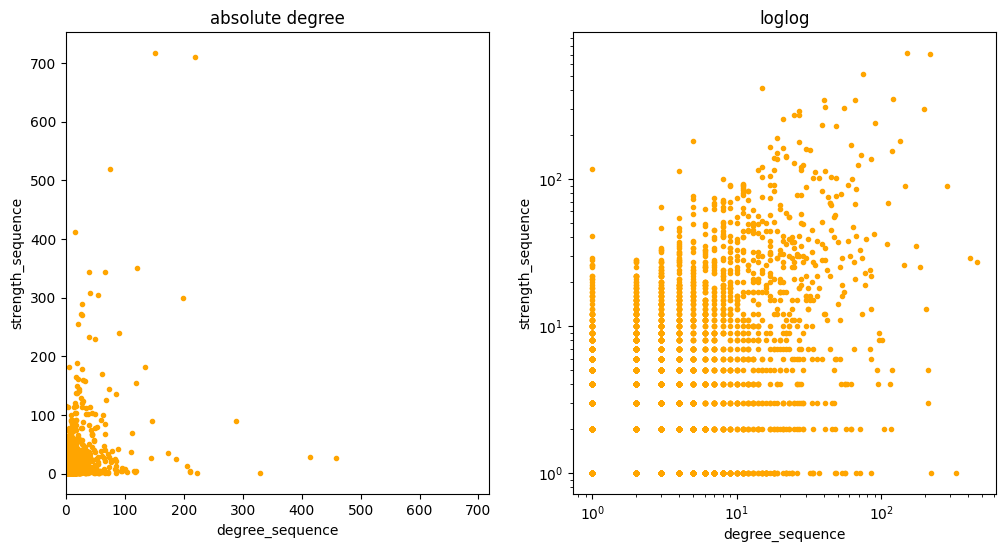

pearson r: 0.40, 0.000


In [66]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.scatter(degree_sequence, strength_sequence, marker=".", color="orange")
ax1.set_title("absolute degree")
ax1.set_ylabel("strength_sequence")
ax1.set_xlabel("degree_sequence")
ax1.set_xlim(0, np.amax(strength_sequence))


ax2.scatter(degree_sequence, strength_sequence, marker=".", color="orange")
ax2.set_title("loglog")
ax2.set_ylabel("strength_sequence")
ax2.set_xlabel("degree_sequence")
ax2.set_yscale('log')
ax2.set_xscale('log')

plt.show()

r, p = stats.pearsonr(degree_sequence, strength_sequence)
print(f"pearson r: {r:.2f}, {p:.3f}")

<br>
<br>

**The result is unsurprisingly positive as the strength of a node will at least be equal to the degree.**

However, interestingly some communities have a low degrees, but high strength, i.e., some communities link with a small number of other communities a lot.

<br>
<br>

### Pruning the network by post volume

A strategy to mitigate the effects of posts from one community about another appearing once versus 100 times, can be to 'filter' the network by some minimum weight, i.e., only consider edges where the posting behaviour happened at least N times.

To examine this we will create a new DiGraph object, F. We will then loop over all of the edges in our weighted network, W, and where the weight is greater than or equal to a certain number, the edge will be added into our new network, F.

In [67]:
# Here we set the minimum weight to be 5 as an initial example. 
# i.e., a subreddit has to have posted about another subreddit at least 5 times of the time period.

threshold = 5

"""
F = nx.DiGraph()
for source, target, data in W.edges(data=True):
    if data['weight'] >= threshold:
        F.add_edge(source, target, weight=data["weight"])
""" 

F = nx.DiGraph(((source, target, data) for source, target, data in W.edges(data=True) if data['weight'] > threshold))



<br>
<br>

#### Smaller network, similar structure

In [68]:
print(f"Number of nodes: {F.number_of_nodes()}")
print(f"Number of edges: {F.number_of_edges()}")
print(f"Total of edge weights: {F.size(weight='weight')} (Number of posts)")

Number of nodes: 309
Number of edges: 250
Total of edge weights: 1839.0 (Number of posts)


In [69]:
print(f"Overall Reciprocity: {nx.overall_reciprocity(F):.3f}")
print(f"Density: {nx.density(F):.4f}")


Overall Reciprocity: 0.016
Density: 0.0026


In [70]:
print(f"Number of strongly connected components: {nx.number_strongly_connected_components(F)}")
print(f"Number of weakly connected components: {nx.number_weakly_connected_components(F)}")

Number of strongly connected components: 307
Number of weakly connected components: 97


**Observations:**
- There is a significant reduction in the number of nodes and edges;
- The network remains similarly sparse with little reciprocity. Although less reciprocity and density relative to the original network;
- The network still has lots of strongly and weakly connected components.

<br>
<br>

#### Stronger signals of node 'roles'

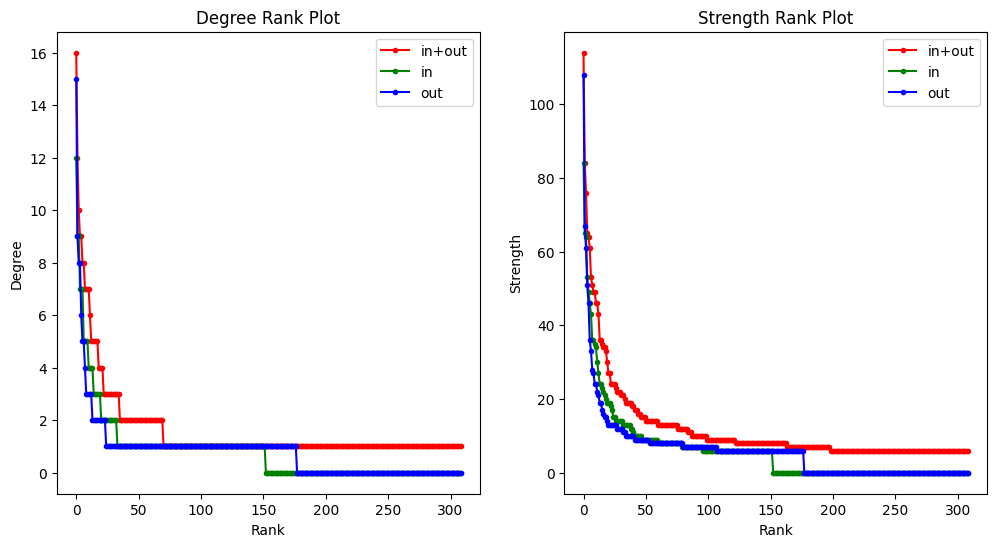

In [71]:
degree_sequence = sorted(dict(F.degree(nodeOrder)).values(), reverse=True)
in_degree_sequence = sorted(dict(F.in_degree(nodeOrder)).values(), reverse=True)
out_degree_sequence = sorted(dict(F.out_degree(nodeOrder)).values(), reverse=True)

strength_sequence = sorted(dict(F.degree(nodeOrder, weight="weight")).values(), reverse=True)
in_strength_sequence = sorted(dict(F.in_degree(nodeOrder, weight="weight")).values(), reverse=True)
out_strength_sequence = sorted(dict(F.out_degree(nodeOrder, weight="weight")).values(), reverse=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.plot(degree_sequence, "r-", marker=".", label="in+out")
ax1.plot(in_degree_sequence, "g-", marker=".", label="in")
ax1.plot(out_degree_sequence, "b-", marker=".", label="out")
ax1.set_title("Degree Rank Plot")
ax1.set_ylabel("Degree")
ax1.set_xlabel("Rank")
ax1.legend()


ax2.plot(strength_sequence, "r-", marker=".", label="in+out")
ax2.plot(in_strength_sequence, "g-", marker=".", label="in")
ax2.plot(out_strength_sequence, "b-", marker=".", label="out")
ax2.set_title("Strength Rank Plot")
ax2.set_ylabel("Strength")
ax2.set_xlabel("Rank")
ax2.legend()

plt.show()

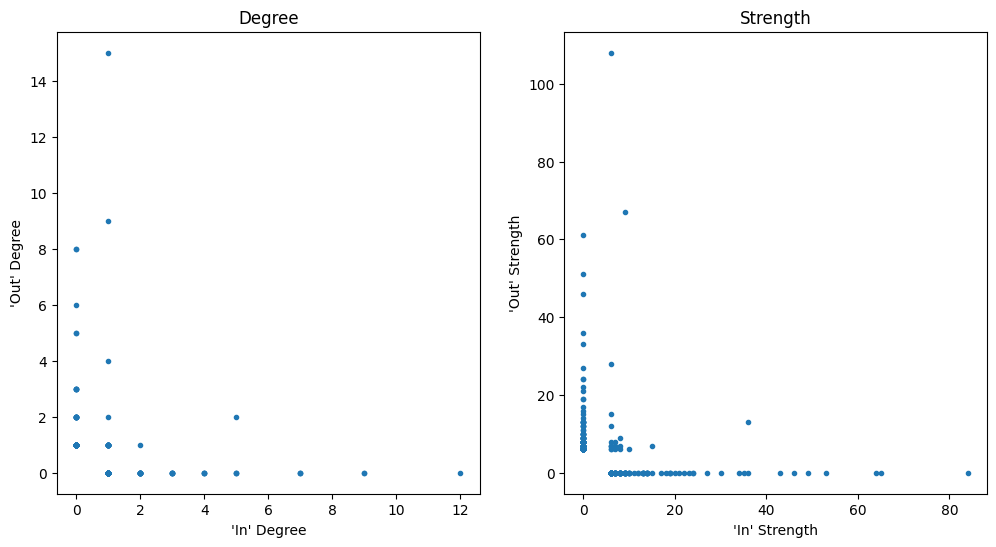

pearson r: -0.241, p: 0.000


In [72]:
degree_sequence = list(dict(F.degree(nodeOrder)).values())
in_degree_sequence = list(dict(F.in_degree(nodeOrder)).values())
out_degree_sequence = list(dict(F.out_degree(nodeOrder)).values())

strength_sequence = list(dict(F.degree(nodeOrder, weight="weight")).values())
in_strength_sequence = list(dict(F.in_degree(nodeOrder, weight="weight")).values())
out_strength_sequence = list(dict(F.out_degree(nodeOrder, weight="weight")).values())


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.scatter(in_degree_sequence, out_degree_sequence, marker=".")
ax1.set_title("Degree")
ax1.set_ylabel("'Out' Degree")
ax1.set_xlabel("'In' Degree")

ax2.scatter(in_strength_sequence, out_strength_sequence, marker=".")
ax2.set_title("Strength")
ax2.set_ylabel("'Out' Strength")
ax2.set_xlabel("'In' Strength")

plt.show()

r, p = stats.pearsonr(in_degree_sequence, out_degree_sequence)
print("pearson r: %.3f, p: %.3f" % (r, p))

<br>
<br>

#### Components are (mostly) small clusters or pairs

In [73]:
scc_components = nx.strongly_connected_components(F)

number_of_nodes_per_component = []
for component in scc_components:
    number_of_nodes_per_component.append(len(component))

number_of_nodes_per_component = sorted(number_of_nodes_per_component, reverse=True)

print(number_of_nodes_per_component[:90])


[2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [74]:
wcc_components = nx.weakly_connected_components(F)

number_of_nodes_per_component = []
for component in wcc_components:
    number_of_nodes_per_component.append(len(component))

number_of_nodes_per_component = sorted(number_of_nodes_per_component, reverse=True)

print(number_of_nodes_per_component[:90], "...")


[89, 8, 6, 5, 5, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2] ...


<br>
<br>

**Lets visualise the network:**

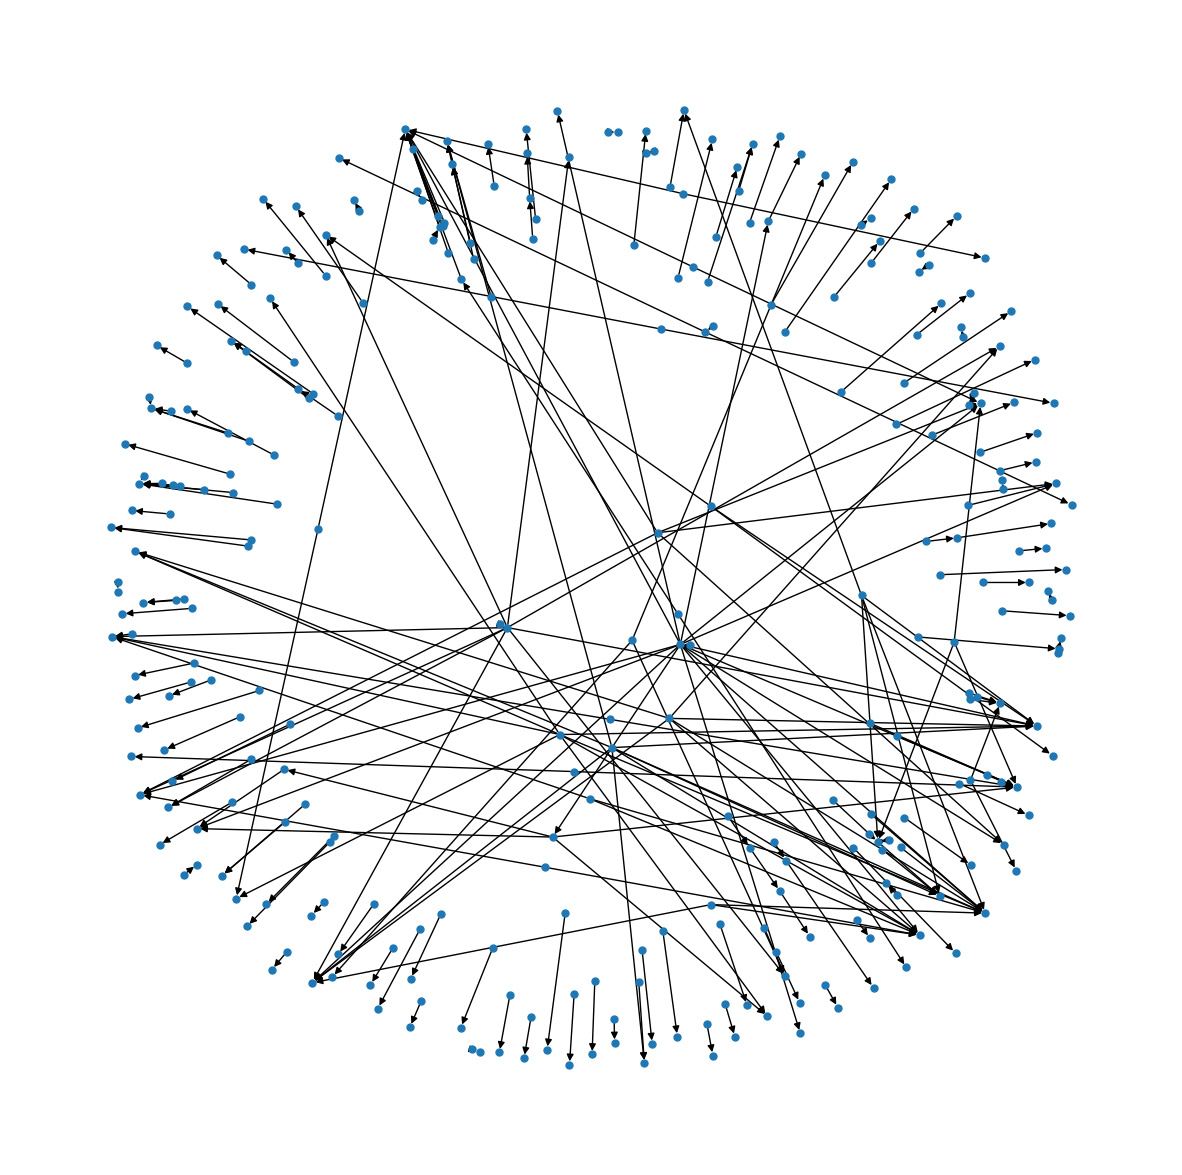

In [75]:
position = nx.spring_layout(F, k=0.1, seed=100)

fig1, ax1 = plt.subplots(figsize=(15, 15))
nx.draw(F, ax=ax1, pos=position, node_size=25)
plt.show()
